# <font color='#1a5276'> <b> <center> Neural Networks </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Example 1](#3) <br>
    3.1. [Helper Functions](#3.1) <br>
    3.2. [Data](#3.2) <br>
    3.3. [Model architecture, training and evaluation](#3.3) <br>
4. [Example 2](#4) <br>
    4.1. [Helper Functions](#4.1) <br>
    4.2. [Data](#4.2) <br>
    4.3. [Model architecture, training and evaluation](#4.3) <br>
5. [Example 3: Noisy XOR](#5) <br>
    5.1. [Helper Functions](#5.1) <br>
    5.2. [Data](#5.2) <br>
    5.3. [Model architecture, training and evaluation](#5.3) <br>
6. [Example 4: MNIST](#5) <br>
    6.1. [Data](#6.1) <br>
    6.2. [Models and training](#6.2) <br>
    6.3. [Model comparisson](#6.3) <br>
9. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

In this notebook, we'll walk through several examples of shallow neural networks using PyTorch. The goal is to learn how to define, train, and evaluate a neural network.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch 
import torch.nn as nn
from torch import sigmoid
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib.colors import ListedColormap
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [3]:
torch.manual_seed(0)

<a name="3"></a>
## <font color='blue'> <b> 3. Example 1 </b> </font>

We will start by implementing the following arquitecture:
    
        Input -> Linear1 -> Sigmoid -> Linear2 -> Sigmoid -> Output
    

<a name="3.1"></a>
### <font color='#1a5276'> <b> 3.1. Helper Functions </b> </font>

In [4]:
# Plots the predictions of a model alongside the actual values, and it labels the plot with the current epoch.
def plot_stuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    plt.xlabel('x')
    if leg == True:
        plt.legend()
    else:
        pass
    
    
# Plot data
def plot_data(X, Y):
    # Convert tensors to NumPy arrays for plotting
    X_np = X.numpy()
    Y_np = Y.numpy()
    
    # Create a scatter plot with X on the x-axis and Y on the y-axis
    plt.scatter(X_np, Y_np, color='blue', label='Data points')
    
    # Label the axes
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # Add a title
    plt.title('Plot of X vs Y')
    
    # Optionally, add a grid for better visualization
    plt.grid(True)
    
    # Show the plot
    plt.show()

<a name="3.2"></a>
### <font color='#1a5276'> <b> 3.2. Data </b> </font>

We will create synthetic data.

In [5]:
# Generate a tensor X with values ranging from -20 to 20 (step size of 1)
X = torch.arange(-20, 20, 1).view(-1, 1).type(torch.FloatTensor)

# Initialize a tensor Y with the same number of rows as X, filled with zeros
Y = torch.zeros(X.shape[0])

# Set Y to 1.0 for values of X between -4 and 4 (exclusive)
Y[(X[:, 0] > -4) & (X[:, 0] < 4)] = 1.0

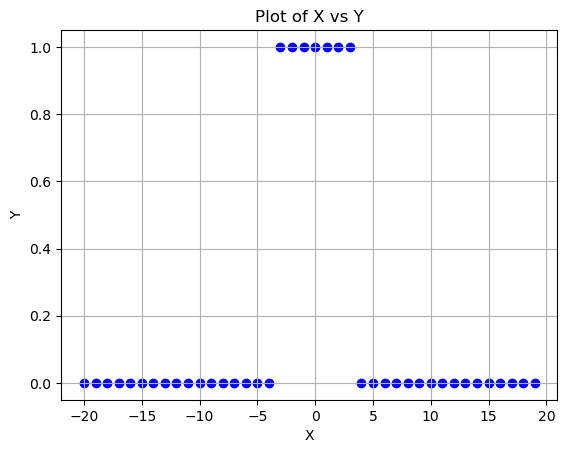

In [6]:
plot_data(X, Y)

<a name="3.3"></a>
### <font color='#1a5276'> <b> 3.3. Model architecture, training and evaluation </b> </font>

In [7]:
# size of input 
D_in = 1

# size of hidden layer 
H = 2

# number of outputs 
D_out = 1

# learning rate 
learning_rate = 0.1

The model will have the following architecture:

<img src="images/SimpleNet.png"/>

<br>
<center> <b> Model architecture </b> </center>

In [8]:
class Net1(nn.Module):
    """
    A simple feedforward neural network with two layers and sigmoid activations.

    This model consists of two fully connected layers (`linear1` and `linear2`),
    with a sigmoid activation applied after the first layer. The model also
    stores intermediate activations (`a1`, `l1`) and outputs predictions (`yhat`).
    These intermediate results are tracked for the purpose of visualizing the activations.
    Although storing activations as attributes is not considered a good practice, it is done here
    for educational purposes and to enable plotting intermediate activations during training.

    Attributes:
    -----------
    a1 : Tensor
        The activations after the first layer (used for visualization).
    l1 : Tensor
        The linear output after the first layer (used for visualization).
    l2 : Tensor
        The output of the second linear layer.
    """

    # Constructor
    def __init__(self, D_in, H, D_out):
        """
        Initialize the network layers.

        Parameters:
        -----------
        D_in : int
            The number of input features.
        H : int
            The number of hidden units in the hidden layer.
        D_out : int
            The number of output units (the dimensionality of the output).
        """
        super(Net1, self).__init__()
        
        # Define the hidden layer (linear1) and the output layer (linear2)
        self.linear1 = nn.Linear(D_in, H)  # First linear layer (input to hidden)
        self.linear2 = nn.Linear(H, D_out)  # Second linear layer (hidden to output)
        
        # Initialize variables to store activations and outputs, used for plotting intermediate results
        self.a1 = None  # Activation after the first layer (hidden layer)
        self.l1 = None  # Output from the first linear layer (before activation)
        self.l2 = None  # Output from the second linear layer (before final activation)
    
    # Prediction (Forward pass)
    def forward(self, x):
        """
        Perform the forward pass through the network.

        This function computes the output `yhat` of the network by passing the input `x` 
        through the first linear layer, applying the sigmoid activation, passing it through 
        the second linear layer, and applying a final sigmoid activation.

        Parameters:
        -----------
        x : Tensor
            The input tensor to the network.

        Returns:
        --------
        yhat : Tensor
            The predicted output of the network (after the final sigmoid activation).
        """
        # First layer: compute linear transformation (l1) and apply activation (a1)
        self.l1 = self.linear1(x)  # Linear transformation from input to hidden
        self.a1 = torch.sigmoid(self.l1)  # Apply sigmoid activation after the first layer
        
        # Second layer: compute output (l2) and final prediction (yhat)
        self.l2 = self.linear2(self.a1)  # Linear transformation from hidden to output
        yhat = torch.sigmoid(self.l2)  # Apply sigmoid activation at the output layer

        # Return the final prediction
        return yhat


In [9]:
# Training function
def train(X, Y, model, optimizer, criterion, epochs=1000):
    """
    Train a neural network model using the given data, optimizer, and loss function.

    This function performs the training loop for the specified number of epochs.
    It computes the forward pass, calculates the loss, performs backpropagation,
    and updates the model parameters using the optimizer. The cumulative loss is
    tracked and plotted every 300 epochs. 

    Parameters:
    -----------
    Y : tensor
        The target output values.
    X : tensor
        The input features.
    model : nn.Module
        The neural network model to be trained.
    optimizer : torch.optim.Optimizer
        The optimizer used to update model parameters.
    criterion : nn.Module
        The loss function used to calculate the error.
    epochs : int, optional
        The number of epochs to train the model (default is 1000).

    Returns:
    --------
    cost : list
        A list containing the cumulative loss at the end of each epoch.
    model : nn.Module
        The trained neural network model after the training loop.
    """
    
    cost = []  # List to track the cost (loss) at each epoch
    total = 0   # Initialize total loss for the epoch
    
    for epoch in range(epochs):
        total = 0  # Reset total loss for the current epoch
        
        for x, y in zip(X, Y):  # Iterate through the data (Y, X) pairs
            yhat = model(x)  # Forward pass: compute model output
            loss = criterion(yhat, y)  # Calculate loss between predictions and target
            
            loss.backward()  # Backpropagation: compute gradients
            optimizer.step()  # Update model parameters
            optimizer.zero_grad()  # Reset gradients to zero for next iteration
            
            # Add the current loss value to the total loss for the epoch
            total += loss.item()  
        
        cost.append(total)  # Append the total loss of the epoch to the cost list
        
        # Plotting the model's predictions and activations every 300 epochs
        if epoch % 300 == 0:    
            plot_stuff(X, Y, model, epoch, leg=True)  # Plot the model predictions
            plt.show()  # Show the plot
            model(X)  # Compute the forward pass to access activations
            
            # Plot the activations of the first hidden layer (a1)
            plt.scatter(model.a1.detach().numpy()[:, 0], 
                        model.a1.detach().numpy()[:, 1], 
                        c=Y.numpy().reshape(-1))
            plt.title('Activations')  # Set the plot title
            plt.show()  # Display the activation plot
    
    return cost, model  # Return the list of cumulative losses and the trained model


In [10]:
# create an instance of the model
model1 = Net1(D_in, H, D_out)

In [11]:
# criterion
def criterion(yhat, y):
    return -torch.mean(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))

In [12]:
#optimizer 
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)

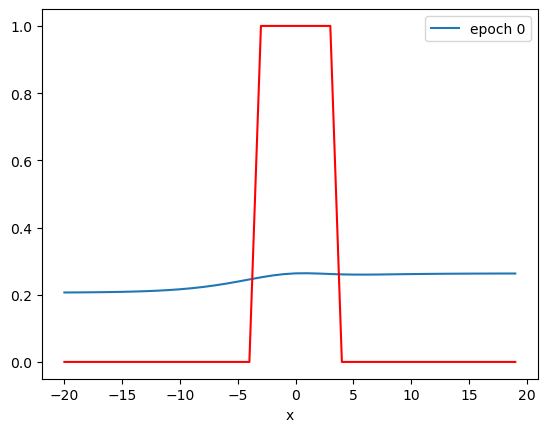

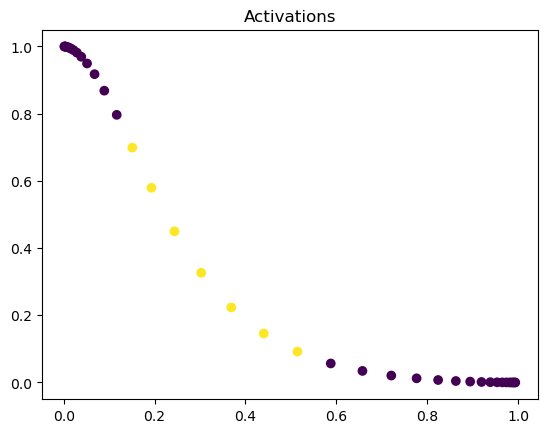

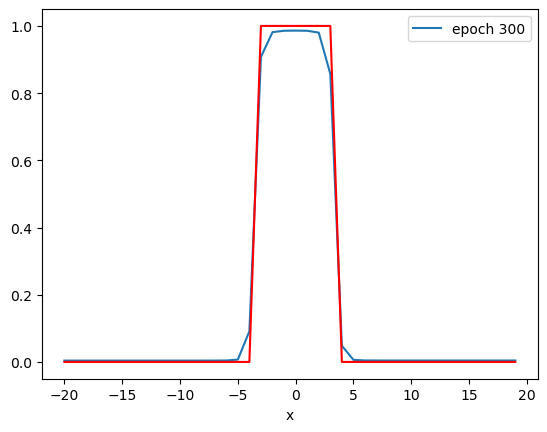

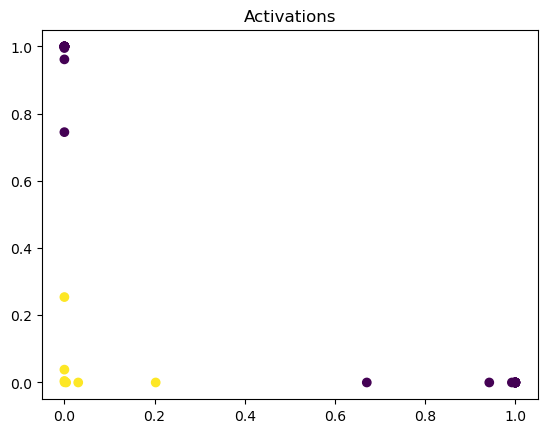

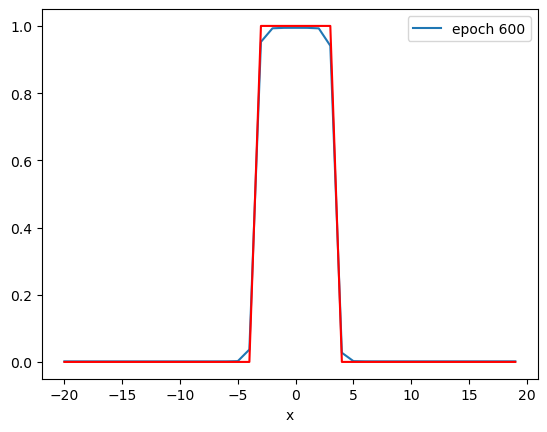

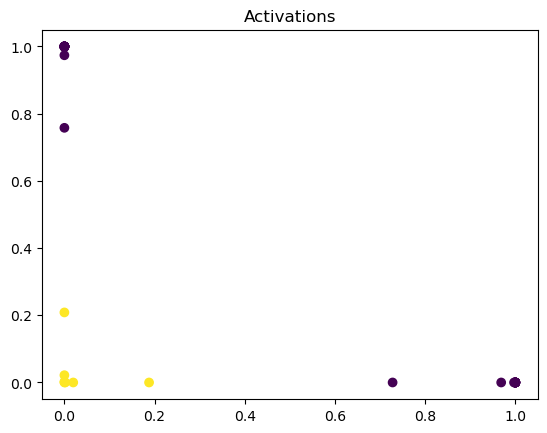

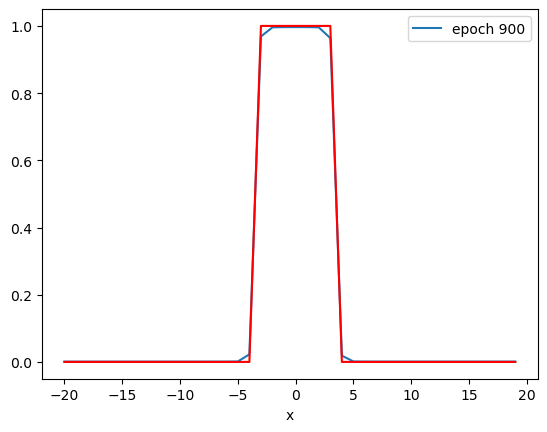

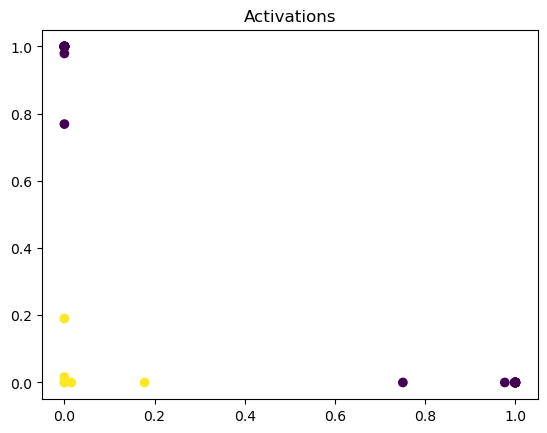

In [13]:
# train the model
cost, trained_model_1 = train(X, Y, model1, optimizer, criterion, epochs=1000)

Examining the activation output, we see that by epoch 600, the data has been mapped to a linearly separable space.

Text(0.5, 1.0, 'Cross-entropy loss')

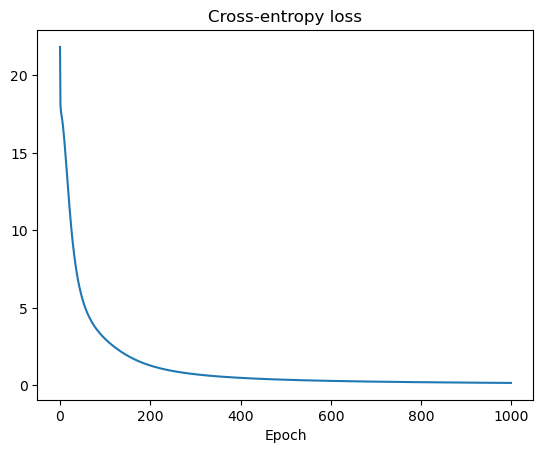

In [14]:
#plot the loss
plt.plot(cost)
plt.xlabel('Epoch')
plt.title('Cross-entropy loss')

### Predictions

In [15]:
# one prediction
x = torch.tensor([0.0])
yhat = trained_model_1(x)
yhat

tensor([0.9969], grad_fn=<SigmoidBackward0>)

In [16]:
# several predictions
X_= torch.tensor([[0.0],[2.0],[3.0]])
Yhat = trained_model_1(X_)
Yhat

tensor([[0.9969],
        [0.9963],
        [0.9680]], grad_fn=<SigmoidBackward0>)

In [17]:
# we can apply a threshold
Yhat = Yhat > 0.5
Yhat

tensor([[True],
        [True],
        [True]])

<a name="4"></a>
## <font color='blue'> <b> 4. Example 2 </b> </font>

Now the data will be a little more complex.

<a name="4.1"></a>
### <font color='#1a5276'> <b> 4.1. Helper Functions </b> </font>


In [18]:
# histogram
def get_hist(model, dataset):
    activations = model.activation(dataset.x)
    for i,activation in enumerate(activations):
        plt.hist(activation.numpy(), 4, density=True)
        plt.title("Activation layer " + str(i+1))
        plt.xlabel("Activation")
        plt.xlabel("Activation")
        plt.legend()
        plt.show()
        
        
# plot training points and predictions
def plot_stuff(X,Y,model=None,leg=False):
    
    plt.plot(X[Y==0].numpy(),Y[Y==0].numpy(),'or',label='training points y=0 ' )
    plt.plot(X[Y==1].numpy(),Y[Y==1].numpy(),'ob',label='training points y=1 ' )

    if model!=None:
        plt.plot(X.numpy(),model(X).detach().numpy(),label='neral network ')

    plt.legend()
    plt.show()


<a name="4.2"></a>
### <font color='#1a5276'> <b> 4.2. Data </b> </font>

In [19]:
class Data(Dataset):
    """
    Custom dataset class for generating synthetic data.

    This dataset generates input data `x` in the range [-20, 20] and creates corresponding labels `y`
    based on specific ranges of `x`. The class implements the PyTorch `Dataset` interface, allowing it 
    to be used with a DataLoader for batch processing.

    - Input `x` is a 100-point tensor of linearly spaced values between -20 and 20.
    - Output `y` is a binary label tensor, where:
        - Label `1` is assigned to values of `x` in the ranges (-10, -5) and (5, 10).
        - Label `0` is assigned to all other values of `x`.

    Attributes:
    ----------
    x : Tensor
        Input data, a 100-point tensor linearly spaced between -20 and 20.
    y : Tensor
        Labels corresponding to the input data. The values are 1 for certain ranges of `x` and 0 otherwise.
    len : int
        The length of the dataset (number of samples).
    """

    def __init__(self):
        """
        Initialize the dataset by generating the input data `x` and the corresponding labels `y`.

        The input data `x` is generated using `torch.linspace` to create 100 linearly spaced values from -20 to 20.
        Labels `y` are assigned based on specific conditions applied to `x`. The labels are 1 for certain
        ranges of `x` and 0 otherwise.

        The length of the dataset is computed as the number of input samples.
        """
        # Generate 100 points linearly spaced between -20 and 20
        self.x = torch.linspace(-20, 20, 100).view(-1, 1)

        # Initialize labels to zeros
        self.y = torch.zeros(self.x.shape[0])

        # Assign label 1 for x values in the range (-10, -5) and (5, 10)
        self.y[(self.x[:, 0] > -10) & (self.x[:, 0] < -5)] = 1
        self.y[(self.x[:, 0] > 5) & (self.x[:, 0] < 10)] = 1

        # Reshape the labels to be column vectors
        self.y = self.y.view(-1, 1)

        # Store the length of the dataset
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        """
        Retrieve the input-output pair at the specified index.

        Parameters:
        -----------
        index : int
            The index of the data sample to retrieve.

        Returns:
        --------
        tuple : (Tensor, Tensor)
            A tuple containing the input data `x` and the corresponding label `y`.
        """
        return self.x[index], self.y[index]

    def __len__(self):
        """
        Return the length of the dataset (number of samples).

        Returns:
        --------
        int
            The number of samples in the dataset.
        """
        return self.len


In [20]:
# create a Data object
dataset = Data()

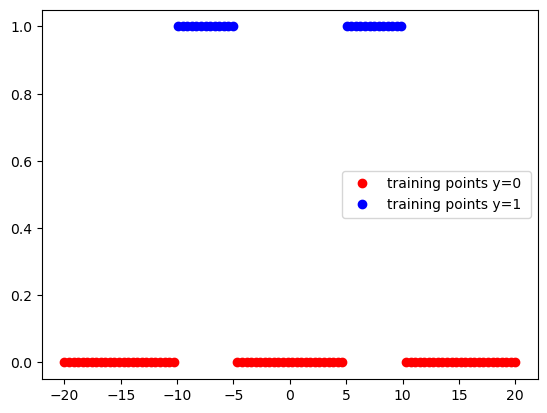

In [21]:
# plot data
plot_stuff(dataset.x, dataset.y, leg=False)

<a name="4.3"></a>
### <font color='#1a5276'> <b> 4.3. Model architecture, training and evaluation </b> </font>

In [22]:
# size of input 
D_in = 1

# size of hidden layer 
H = 9

# number of outputs 
D_out = 1

# learning rate 
learning_rate = 0.1

The model will have the following architecture:

<img src="images/SimpleNet.png"/>

<br>
<center> <b> Model architecture </b> </center>

In [23]:
# Model architecture
class Net2(nn.Module):
    """
    A simple neural network with one hidden layer.

    Attributes:
    -----------
    linear1 : nn.Linear
        The first linear layer that maps input features to the hidden layer.
    linear2 : nn.Linear
        The second linear layer that maps the hidden layer to the output.

    Methods:
    --------
    forward(x):
        Defines the forward pass of the neural network.
    """

    def __init__(self, D_in, H, D_out):
        """
        Initialize the neural network.

        Parameters:
        -----------
        D_in : int
            The number of input features.
        H : int
            The number of neurons in the hidden layer.
        D_out : int
            The number of output features.
        """
        super(Net2, self).__init__()
        # Define the first linear layer (input to hidden)
        self.linear1 = nn.Linear(D_in, H)
        # Define the second linear layer (hidden to output)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Perform the forward pass through the network.

        Parameters:
        -----------
        x : torch.Tensor
            The input tensor.

        Returns:
        --------
        torch.Tensor
            The output tensor after passing through the network.
        """
        # Pass input through the first layer and apply sigmoid activation
        x = torch.sigmoid(self.linear1(x))
        # Pass the result through the second layer and apply sigmoid activation
        x = torch.sigmoid(self.linear2(x))
        return x


In [24]:
# Training function
def train(dataset, model, criterion, train_loader, optimizer, epochs=5, plot_number=10):
    """
    Train a neural network model.

    Parameters:
    -----------
    dataset : Dataset
        The dataset object containing the input data and labels.
    model : nn.Module
        The neural network model to be trained.
    criterion : loss function
        The loss function used to compute the error between predictions and true labels.
    train_loader : DataLoader
        DataLoader object to load the training data in batches.
    optimizer : torch.optim.Optimizer
        The optimizer used to update the model's parameters.
    epochs : int, optional (default=5)
        The number of epochs (full passes through the dataset) to train the model.
    plot_number : int, optional (default=10)
        The frequency of plotting the model's performance during training.

    Returns:
    --------
    tuple:
        - cost : list
            The total loss for each epoch.
        - model : nn.Module
            The trained model.
    """

    cost = []  # List to store the total loss for each epoch
    
    for epoch in range(epochs):
        total = 0  # Accumulator for the total loss during the epoch
        
        for x, y in train_loader:
            # Zero the gradients to prevent accumulation
            optimizer.zero_grad()
            
            # Forward pass: compute predictions
            yhat = model(x)
            
            # Compute the loss
            loss = criterion(yhat, y)
            
            # Backward pass: compute gradients
            loss.backward()
            
            # Update model parameters
            optimizer.step()
            
            # Accumulate the loss
            total += loss.item()
            
            # Optionally plot intermediate results every 'plot_number' epochs
            if epoch % plot_number == 0:
                plot_stuff(dataset.x, dataset.y, model)
        
        # Append the total loss for the current epoch to the cost list
        cost.append(total)
    
    # Plot the cost over epochs
    plt.figure()
    plt.plot(cost)
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Training Cost vs. Epochs')
    plt.show()
    
    # Return the cost history and the trained model
    return cost, model


In [25]:
# instance of Net2
model_2 = Net2(D_in, H, D_out)

# criterion
criterion = nn.BCELoss()

# optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr = learning_rate)

# train loader
train_loader = DataLoader(dataset = dataset, batch_size=100)

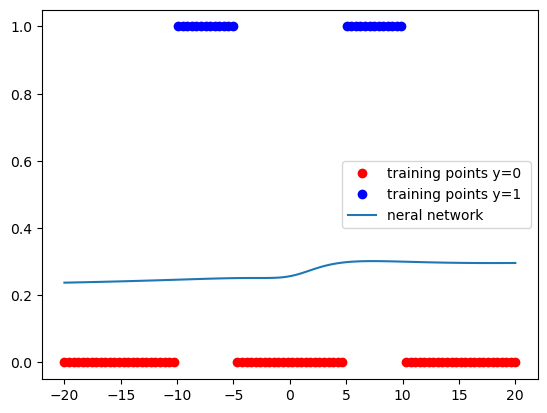

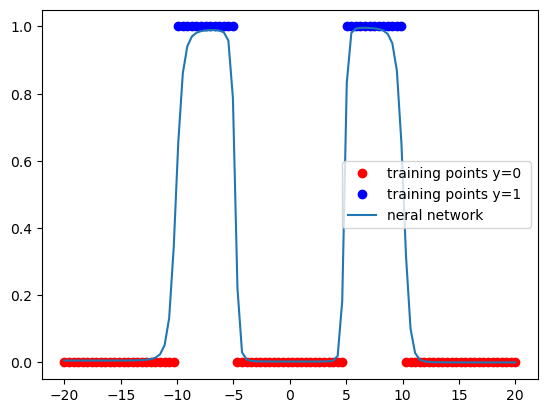

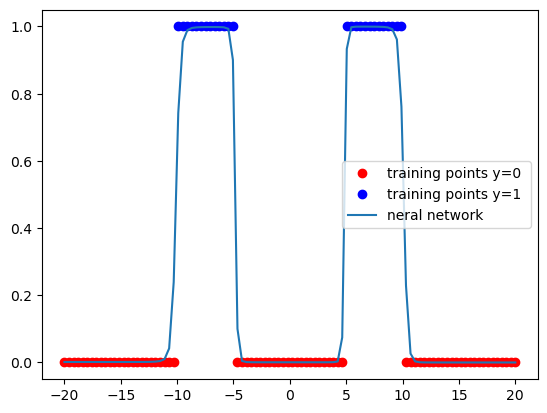

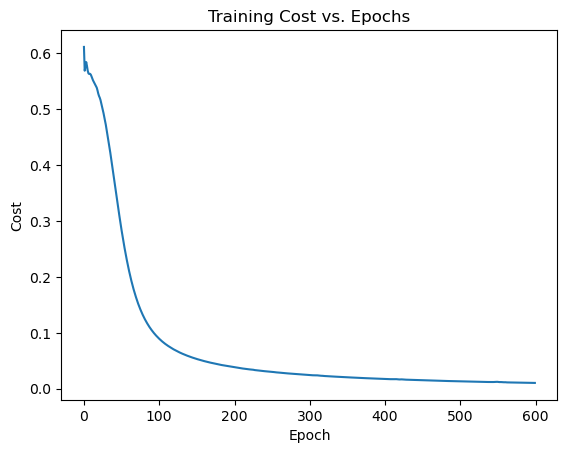

In [26]:
# train
cost, trained_model_2 = train(dataset, model_2 , criterion, train_loader, optimizer, epochs=600,plot_number=200)

<a name="5"></a>
## <font color='blue'> <b> 5. Example 3: Noisy XOR </b> </font>

<a name="5.1"></a>
### <font color='#1a5276'> <b> 5.1. Helper Functions </b> </font>

In [27]:
# Plot decision regions
def plot_decision_regions_2class(model, dataset):
    # Define color maps for the decision regions and data points
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])  # Light colors for background regions
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])   # Bold colors for data points

    # Extract input features (X) and labels (y) from the dataset as numpy arrays
    X = dataset.x.numpy()
    y = dataset.y.numpy()

    # Define the step size for the mesh grid
    h = .02

    # Calculate the minimum and maximum values for X and y axes, adding a small margin
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Create a mesh grid of points to evaluate the decision boundary
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Combine the mesh grid points into a tensor for model input
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    # Use the model to predict the class labels for each point in the mesh grid
    # Logical negation ensures class 0 corresponds to False and class 1 corresponds to True
    yhat = np.logical_not((model(XX)[:, 0] > 0.5).numpy()).reshape(xx.shape)

    # Plot the decision regions as a colored background
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)

    # Plot the data points, using different colors for different classes
    plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'o', label='y=0')  # Class 0
    plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'ro', label='y=1')  # Class 1

    # Add a title and legend to the plot
    plt.title("decision region")
    plt.legend()

    
    
# Calculate accuracy
def accuracy(model, dataset):
    return np.mean(dataset.y.view(-1).numpy() == (model(dataset.x)[:, 0] > 0.5).numpy())

<a name="5.2"></a>
### <font color='#1a5276'> <b> 5.2. Data </b> </font>

In [28]:
# Define the class XOR_Data
class XOR_Data(Dataset):
    """
    A custom PyTorch Dataset for generating and managing XOR-pattern data.
    
    Attributes:
        x (torch.Tensor): A tensor of input features with shape (N_s, 2).
        y (torch.Tensor): A tensor of labels with shape (N_s, 1).
        len (int): The number of samples in the dataset.

    Methods:
        __getitem__(index): Retrieves a specific sample (x, y) by index.
        __len__(): Returns the total number of samples in the dataset.
        plot_stuff(): Plots the data points with different colors for each label.
    """

    # Constructor
    def __init__(self, N_s=100):
        """
        Initializes the XOR_Data dataset with N_s samples.
        
        Args:
            N_s (int): Total number of samples to generate. Must be divisible by 4.
        """
        # Initialize tensors for input features and labels
        self.x = torch.zeros((N_s, 2))  # Input features (2D points)
        self.y = torch.zeros((N_s, 1))  # Corresponding labels

        # Generate XOR data
        for i in range(N_s // 4):
            # Bottom-left quadrant (class 0)
            self.x[i, :] = torch.Tensor([0.0, 0.0])
            self.y[i, 0] = torch.Tensor([0.0])

            # Top-left quadrant (class 1)
            self.x[i + N_s // 4, :] = torch.Tensor([0.0, 1.0])
            self.y[i + N_s // 4, 0] = torch.Tensor([1.0])

            # Bottom-right quadrant (class 1)
            self.x[i + N_s // 2, :] = torch.Tensor([1.0, 0.0])
            self.y[i + N_s // 2, 0] = torch.Tensor([1.0])

            # Top-right quadrant (class 0)
            self.x[i + 3 * N_s // 4, :] = torch.Tensor([1.0, 1.0])
            self.y[i + 3 * N_s // 4, 0] = torch.Tensor([0.0])

        # Add Gaussian noise to input features for variability
        self.x = self.x + 0.01 * torch.randn((N_s, 2))

        # Store the total number of samples
        self.len = N_s

    # Getter
    def __getitem__(self, index):    
        """
        Retrieves the input features and label for a specific sample.
        
        Args:
            index (int): Index of the sample to retrieve.
        
        Returns:
            tuple: A tuple containing input features (x) and the corresponding label (y).
        """
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
            int: Total number of samples.
        """
        return self.len

    # Plot the data
    def plot_stuff(self, figsize):
        """
        Visualizes the dataset by plotting the data points, with different colors for each class.
        """
        
        # Set the figure size
        plt.figure(figsize=figsize)
        
        # Plot data points for class 0
        plt.plot(self.x[self.y[:, 0] == 0, 0].numpy(), self.x[self.y[:, 0] == 0, 1].numpy(), 'o', label="y=0")

        # Plot data points for class 1
        plt.plot(self.x[self.y[:, 0] == 1, 0].numpy(), self.x[self.y[:, 0] == 1, 1].numpy(), 'ro', label="y=1")

        # Add a legend to the plot
        plt.legend()


In [29]:
# create a XOR_data object
dataset = XOR_Data()

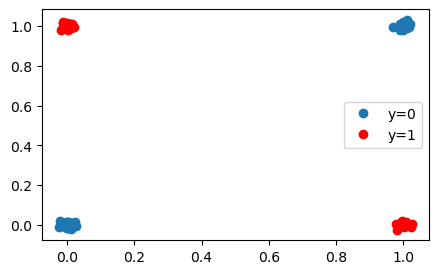

In [30]:
# plot
dataset.plot_stuff((5,3))

<a name="5.3"></a>
### <font color='#1a5276'> <b> 5.3. Model, training and evaluation </b> </font>


The model will have the following architecture:

<img src="images/SimpleNet.png"/>

<br>
<center> <b> Model architecture </b> </center>

In [31]:
# Model architecture
class Net3(nn.Module):
    """
    A simple neural network with one hidden layer.

    Attributes:
    -----------
    linear1 : nn.Linear
        The first linear layer that maps input features to the hidden layer.
    linear2 : nn.Linear
        The second linear layer that maps the hidden layer to the output.

    Methods:
    --------
    forward(x):
        Defines the forward pass of the neural network.
    """

    def __init__(self, D_in, H, D_out):
        """
        Initialize the neural network.

        Parameters:
        -----------
        D_in : int
            The number of input features.
        H : int
            The number of neurons in the hidden layer.
        D_out : int
            The number of output features.
        """
        super(Net3, self).__init__()
        # Define the first linear layer (input to hidden)
        self.linear1 = nn.Linear(D_in, H)
        # Define the second linear layer (hidden to output)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Perform the forward pass through the network.

        Parameters:
        -----------
        x : torch.Tensor
            The input tensor.

        Returns:
        --------
        torch.Tensor
            The output tensor after passing through the network.
        """
        # Pass input through the first layer and apply sigmoid activation
        x = torch.sigmoid(self.linear1(x))
        # Pass the result through the second layer and apply sigmoid activation
        x = torch.sigmoid(self.linear2(x))
        return x


In [32]:
# Define the train model function
def train(dataset, model, criterion, train_loader, optimizer, epochs=5):
    """
    Trains a given model using the specified dataset, loss function, data loader, optimizer, and number of epochs.
    
    Args:
        data_set: The dataset containing input features and labels.
        model: The model to be trained.
        criterion: The loss function to measure the model's performance.
        train_loader: DataLoader for iterating through the training data in batches.
        optimizer: Optimization algorithm for updating model parameters.
        epochs (int): The number of epochs to train the model. Default is 5.
        
    Returns:
        cost: A list of total loss values per epoch.
        model: The trained model.
    """
    # Initialize lists to track total loss and accuracy for each epoch
    cost = []  # Stores total loss per epoch
    acc = []   # Stores accuracy per epoch

    # Loop through the specified number of epochs
    for epoch in range(epochs):
        total = 0  # Initialize cumulative loss for the epoch

        # Loop through each batch in the training data
        for x, y in train_loader:
            optimizer.zero_grad()  # Reset gradients from the previous step
            yhat = model(x)        # Forward pass: Predict output
            loss = criterion(yhat, y)  # Compute loss
            loss.backward()        # Backward pass: Compute gradients
            optimizer.step()       # Update model parameters

            # Accumulate the loss for the current batch
            total += loss.item()

        # Append the epoch's accuracy and loss to their respective lists
        acc.append(accuracy(model, dataset))  # Evaluate model accuracy
        cost.append(total)                     # Store total loss

    # Plot the total loss and accuracy across epochs
    fig, ax1 = plt.subplots()
    
    # Plot total loss on the left y-axis
    color = 'tab:red'
    ax1.plot(cost, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    # Plot accuracy on the right y-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(acc, color=color)
    ax2.tick_params(axis='y', color=color)
    
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.show()          # Display the plots

    return cost, model


In [33]:
# dataloader, learning rate and criterion
train_loader = DataLoader(dataset=dataset, batch_size=1)
learning_rate = 0.1
criterion = nn.BCELoss()

In [34]:
# model with 2 neurons
model = Net3(2, 2, 1)

In [35]:
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

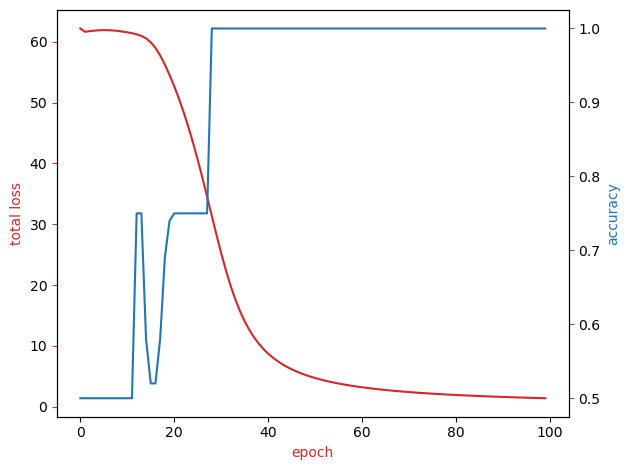

In [36]:
# train
cost, trained_model = train(dataset, model, criterion, train_loader, optimizer, epochs = 100)

In [38]:
accuracy(trained_model, dataset)

1.0

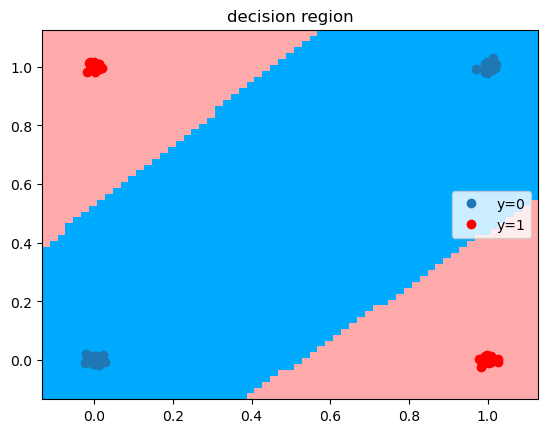

In [40]:
plot_decision_regions_2class(trained_model, dataset)

<a name="6"></a>
## <font color='blue'> <b> 6. Example 4:MNIST </b> </font>

<a name="6.1"></a>
### <font color='#1a5276'> <b> 6.1. Data </b> </font>

In [41]:
# Create the training dataset
train_dataset = dsets.MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())

# Create the validation  dataset
validation_dataset = dsets.MNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

In [42]:
# Create the training data loader and validation data loader object
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

<a name="6.2"></a>
### <font color='#1a5276'> <b> 6.2. Models and training </b> </font>

In [43]:
# data
input_dim = 28 * 28 # 28x28 grey scale images
hidden_dim = 100 # number of neurons of the hidden layer 
output_dim = 10 # 10 classes (digits from 0 to 9)
learning_rate = 0.01

In [44]:
# Build the model with a configurable activation function
class Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H, D_out, activation_fn=torch.sigmoid):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        self.activation_fn = activation_fn  # Store the activation function

    # Prediction
    def forward(self, x):
        x = self.activation_fn(self.linear1(x))  # Use the provided activation function
        x = self.linear2(x)
        return x

# Example usage
#model = Net(D_in=10, H=20, D_out=5, activation_fn=torch.relu)  # Using ReLU as activation


In [45]:
# criterion
criterion = nn.CrossEntropyLoss()

In [46]:
# train function
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    """
    Trains a given model using the provided data loaders and optimizer, and tracks performance metrics.
    
    Args:
        model (torch.nn.Module): The model to be trained.
        criterion (torch.nn.Module): The loss function.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        validation_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        epochs (int): Number of epochs to train the model. Default is 100.
        
    Returns:
        tuple: 
            - metrics (dict): Dictionary containing `training_loss` and `validation_accuracy` as lists.
            - model (torch.nn.Module): The trained model.
    """
    # Initialize the metrics dictionary to track training loss and validation accuracy
    metrics = {'training_loss': [], 'validation_accuracy': []}

    # Training loop over the specified number of epochs
    for epoch in range(epochs):
        # Loop over batches in the training loader
        for i, (x, y) in enumerate(train_loader):
            # Zero the gradients from the previous batch
            optimizer.zero_grad()

            # Flatten the input and make predictions
            yhat = model(x.view(-1, 28 * 28))

            # Compute the loss
            loss = criterion(yhat, y)

            # Backpropagate the loss
            loss.backward()

            # Update the model parameters
            optimizer.step()

            # Record the training loss
            metrics['training_loss'].append(loss.item())
        
        # Validation phase
        correct = 0  # Initialize the counter for correct predictions
        for x, y in validation_loader:
            # Flatten the input and make predictions
            yhat = model(x.view(-1, 28 * 28))

            # Get the predicted labels
            _, label = torch.max(yhat, 1)

            # Count the number of correct predictions
            correct += (label == y).sum().item()
        
        # Compute validation accuracy
        accuracy = 100 * (correct / len(validation_dataset))
        metrics['validation_accuracy'].append(accuracy)

    # Return the metrics and the trained model
    return metrics, model


### Model 1: Sigmoid

In [47]:
model_sigmoid = Net(input_dim, hidden_dim, output_dim, torch.sigmoid)

optimizer_sigmoid = torch.optim.SGD(model_sigmoid.parameters(), lr=learning_rate)

metrics_model_sigmoid, trained_model_sigmoid = train(model_sigmoid, criterion, train_loader, validation_loader, 
                                         optimizer_sigmoid, epochs=30)

### Model 2: Tanh

In [48]:
model_tanh = Net(input_dim, hidden_dim, output_dim, torch.tanh)

optimizer_tanh = torch.optim.SGD(model_tanh.parameters(), lr=learning_rate)

metrics_model_tanh, trained_model_tanh = train(model_tanh, criterion, train_loader, validation_loader, 
                                               optimizer_tanh, epochs=30)

### Model 3: ReLU

In [49]:
model_relu = Net(input_dim, hidden_dim, output_dim, torch.relu)

optimizer_relu = torch.optim.SGD(model_relu.parameters(), lr=learning_rate)

metrics_model_relu, trained_model_relu = train(model_relu, criterion, train_loader, validation_loader, 
                                               optimizer_relu, epochs=30)

<a name="6.3"></a>
### <font color='#1a5276'> <b> 6.3. Model comparisson </b> </font>

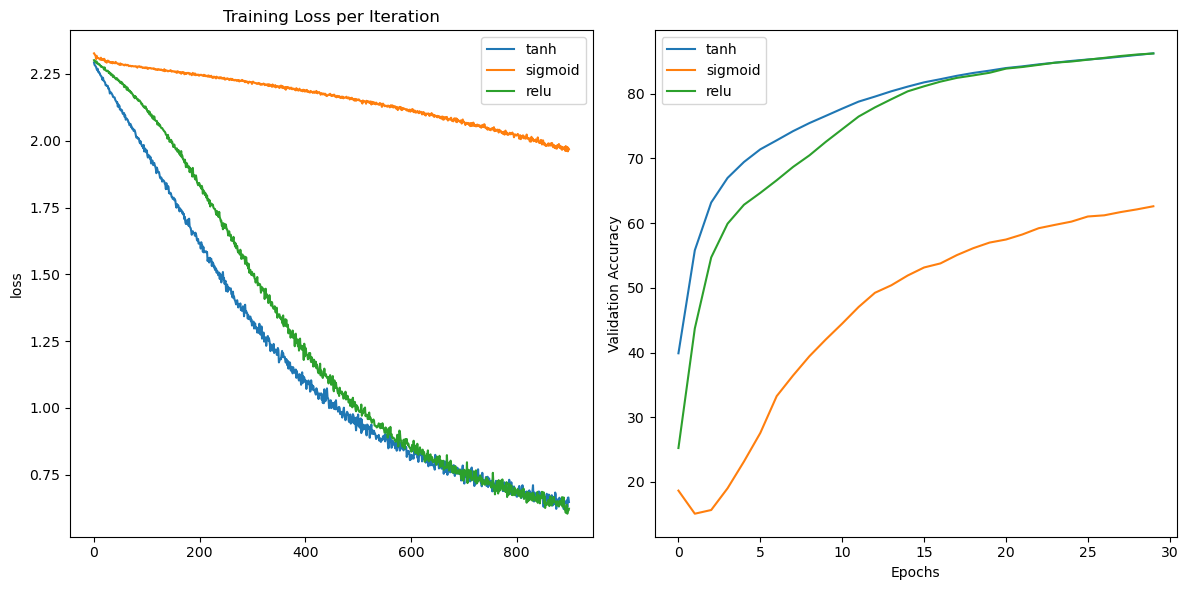

In [51]:
# Create a figure and a 1x2 grid of subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training loss on the first subplot (ax1)
ax1.plot(metrics_model_tanh['training_loss'], label='tanh')
ax1.plot(metrics_model_sigmoid['training_loss'], label='sigmoid')
ax1.plot(metrics_model_relu['training_loss'], label='relu')
ax1.set_ylabel('loss')
ax1.set_title('Training Loss per Iteration')
ax1.legend()

# Plot validation accuracy on the second subplot (ax2)
ax2.plot(metrics_model_tanh['validation_accuracy'], label='tanh')
ax2.plot(metrics_model_sigmoid['validation_accuracy'], label='sigmoid')
ax2.plot(metrics_model_relu['validation_accuracy'], label='relu')
ax2.set_ylabel('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

We can see that we get much better results using ReLU and tanh instead of sigmoid.

<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)

[PyTorch documentation](https://pytorch.org/docs/stable/index.html)